(4311220224, 12806062080)


/tmp/ipykernel_230539/3918982448.py:25: RuntimeWarning:

All-NaN slice encountered



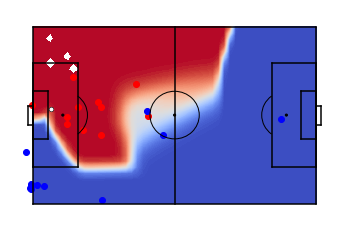

In [14]:
import pandas as pd
import numpy as np
import torch

# away_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv', skiprows=2)
# home_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv', skiprows=2)
# home_data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/tracking_team_home.csv")
# away_data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/tracking_team_away.csv")
FIRST_GAME_FRAME = 1131
home_data = pd.read_parquet('tracking_team1-5.parquet').iloc[FIRST_GAME_FRAME:,:].reset_index(drop=True)
away_data = pd.read_parquet("tracking_team2-5.parquet").iloc[FIRST_GAME_FRAME:,:].reset_index(drop=True)

num_home_team_players = (len(home_data.columns)-5)//2
num_away_team_players = (len(away_data.columns)-5)//2
locs_home = np.array([np.asarray(home_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(num_home_team_players)]) * np.array([105,68])
locs_away = np.array([np.asarray(away_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(num_away_team_players)]) * np.array([105,68])
locs_ball = np.asarray(home_data.iloc[:,-2:]) * np.array([105,68])
tt = home_data['Time [s]']
# event_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawEventsData.csv')

torch.cuda.set_device(3)
print(torch.cuda.mem_get_info(torch.cuda.current_device()))
device = torch.cuda.current_device()

np.nanmax(locs_home, axis=0)

"""## Pre-compute quantities required for pitch-control

Precompute required pitch control quantities for all frames simultaneously. Mostly correspond to quantities in appendix of paper, should be clear from variable names what corresponds to what.
"""

jitter = 1e-12 # to avoid division by zero when players are standing still

# GPU versions of data
# xy_home = torch.Tensor(locs_home).cuda()
# xy_away = torch.Tensor(locs_away).cuda()
# xy_ball = torch.Tensor(locs_ball).cuda()

xy_home = torch.Tensor(locs_home).cuda('cuda:3')
xy_away = torch.Tensor(locs_away).cuda('cuda:3')
xy_ball = torch.Tensor(locs_ball).cuda('cuda:3')

ttt = torch.Tensor(tt).cuda('cuda:3')
# x & y velocity components
dt = ttt[1:] - ttt[:-1]
sxy_home = (xy_home[:,1:,:] - xy_home[:,:-1,:])/dt[:,None] + jitter
sxy_away = (xy_away[:,1:,:] - xy_away[:,:-1,:])/dt[:,None] + jitter
# velocities
s_home = torch.sqrt(torch.sum(sxy_home**2,2))
s_away = torch.sqrt(torch.sum(sxy_away**2,2))
# angles of travel
theta_home = torch.acos(sxy_home[:,:,0] / s_home)
theta_away = torch.acos(sxy_away[:,:,0] / s_away)
# means for player influence functions
mu_home = xy_home[:,:-1,:] + 0.5*sxy_home
mu_away = xy_away[:,:-1,:] + 0.5*sxy_away
# proportion of max. speed
Srat_home = torch.min((s_home / 13.0)**2,torch.Tensor([1]).cuda('cuda:3'))
Srat_away = torch.min((s_away / 13.0)**2,torch.Tensor([1]).cuda('cuda:3'))
# influence radius
Ri_home = torch.min(4 + torch.sqrt(torch.sum((xy_ball - xy_home)**2,2))**3 / 972,torch.Tensor([10]).cuda('cuda:3'))
Ri_away = torch.min(4 + torch.sqrt(torch.sum((xy_ball - xy_away)**2,2))**3 / 972,torch.Tensor([10]).cuda('cuda:3'))
# inverses of covariance matrices -- Sigma^{-1} = RS^{-1}S^{-1}R^T. only need RS^{-1} to evaluate gaussian.
RSinv_home = torch.Tensor(s_home.shape[0],s_home.shape[1],2,2).cuda('cuda:3')
RSinv_away = torch.Tensor(s_home.shape[0],s_home.shape[1],2,2).cuda('cuda:3')

S1_home = 2 / ((1+Srat_home) * Ri_home[:,:-1])
S2_home = 2 / ((1-Srat_home) * Ri_home[:,:-1])
S1_away = 2 / ((1+Srat_away) * Ri_away[:,:-1])
S2_away = 2 / ((1-Srat_away) * Ri_away[:,:-1])

RSinv_home[:,:,0,0] = S1_home * torch.cos(theta_home)
RSinv_home[:,:,1,0] = S1_home * torch.sin(theta_home)
RSinv_home[:,:,0,1] = - S2_home * torch.sin(theta_home)
RSinv_home[:,:,1,1] = S2_home * torch.cos(theta_home)

RSinv_away[:,:,0,0] = S1_away * torch.cos(theta_away)
RSinv_away[:,:,1,0] = S1_away * torch.sin(theta_away)
RSinv_away[:,:,0,1] = - S2_away * torch.sin(theta_away)
RSinv_away[:,:,1,1] = S2_away * torch.cos(theta_away)
# denominators for individual player influence functions (see eq 1 in paper). Note the normalising factors for the multivariate normal distns (eq 12) 
#cancel, so don't need to bother computing them.
denominators_h = torch.exp(-0.5 * torch.sum(((xy_home[:,:-1,None,:] - mu_home[:,:,None,:]).matmul(RSinv_home))**2,-1))
denominators_a = torch.exp(-0.5 * torch.sum(((xy_away[:,:-1,None,:] - mu_away[:,:,None,:]).matmul(RSinv_away))**2,-1))

# set up query points for evaluating pitch control
n_grid_points_x = 50
n_grid_points_y = 30
xy_query = torch.stack([torch.linspace(0,105,n_grid_points_x).cuda('cuda:3').repeat(n_grid_points_y),torch.repeat_interleave(torch.linspace(0,68,n_grid_points_y).cuda('cuda:3'),n_grid_points_x)],1)

"""Now we can compute the pitch control at the query points for whichever frames we care about. There might be a memory error if you use a finer grid of query points, but we can process the whole match under the current settings. If there's a memory error, try reducing the batch size.

# Standard Wide Open Spaces implementation
"""

# specify frames of interest
first_frame = 0
n_frames = sxy_home.shape[1]

# add some dimensions to query array for broadcasting purposes
xyq = xy_query[None,None,:,:]
pitch_control = torch.Tensor(n_frames,xy_query.shape[0]).cuda('cuda:3')
#batch_size sets number of frames to be processed at once. decrease if there's a cuda memory error.
batch_size = 2000
for f in range(int(n_frames/batch_size) + 1):
  # subtract means from query points
  xminmu_h = mu_home[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),None,:] - xyq
  # multiply (mu - x) obtained above by RS^{-1}
  mm_h = xminmu_h.matmul(RSinv_home[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:,:])
  infl_h = torch.exp(-0.5 * torch.sum(mm_h**2,-1))
  infl_h = infl_h / denominators_h[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:]
  xminmu_a = mu_away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),None,:] - xyq
  mm_a = xminmu_a.matmul(RSinv_away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:,:])
  infl_a = torch.exp(-0.5 * torch.sum(mm_a**2,-1))
  infl_a = infl_a / denominators_a[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:]
  isnan_h = torch.isnan(infl_h)
  isnan_a = torch.isnan(infl_a)
  infl_h[isnan_h] = 0
  infl_a[isnan_a] = 0
  pitch_control[(f*batch_size):(np.minimum((f+1)*batch_size,int(n_frames))),:] = torch.sigmoid(torch.sum(infl_h,0) - torch.sum(infl_a,0))

"""# Modified Wide Open Spaces
  - Includes pitch control per player
  - Gives more control of distant empty areas to one team or the other, rather than sharing it between the two teams.
"""

# specify frames of interest
first_frame = 0
n_frames = sxy_home.shape[1]
return_pcpp = False

# add some dimensions to query array for broadcasting purposes
xyq = xy_query[None,None,:,:]
pitch_control = torch.Tensor(n_frames,xy_query.shape[0]).cuda('cuda:3')
if return_pcpp:
  pcpp = torch.Tensor(28,n_frames,xy_query.shape[0]).cuda('cuda:3')
#batch_size sets number of frames to be processed at once. decrease if there's a cuda memory error.
batch_size = 1000
for f in range(int(n_frames/batch_size) + 1):
  # subtract means from query points
  xminmu_h = mu_home[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),None,:] - xyq
  # multiply (mu - x) obtained above by RS^{-1}
  mm_h = xminmu_h.matmul(RSinv_home[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:,:])
  infl_h = torch.exp(-0.5 * torch.sum(mm_h**2,-1))
  infl_h = infl_h / denominators_h[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:]
  xminmu_a = mu_away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),None,:] - xyq
  mm_a = xminmu_a.matmul(RSinv_away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:,:])
  infl_a = torch.exp(-0.5 * torch.sum(mm_a**2,-1))
  infl_a = infl_a / denominators_a[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:]
  isnan_h = torch.isnan(infl_h)
  isnan_a = torch.isnan(infl_a)
  infl_h[isnan_h] = 0
  infl_a[isnan_a] = 0
  ## rather than putting influence functions through a sigmoid function, just set individual player's control over a location to be
  ## their proportion of the total influence at that location.
  pc = torch.cat([infl_h,infl_a]) / torch.sum(torch.cat([infl_h,infl_a]),0)
  if return_pcpp:
    pcpp[:,(f*batch_size):(np.minimum((f+1)*batch_size,int(n_frames))),:] = pc
  ## the home team's control over a location is then just the sum of this new per-player control over all players from the home team.
  pitch_control[(f*batch_size):(np.minimum((f+1)*batch_size,int(n_frames))),:] = torch.sum(pc[0:14],0)

"""# Optional post-processing to increase resolution

Optionally, you can increase the resolution using bicubic interpolation. You might lose a bit of accuracy, but it's a lot faster than computing pitch control explicitly on a finer grid. Again, you might need to play with the batch size to avoid memory errors if you push the resolution higher.
"""

pc = pitch_control.reshape(pitch_control.shape[0],n_grid_points_y,n_grid_points_x)

#upsample resolution to 105x68
n_interp_x = 105
n_interp_y = 68
#pre-allocate tensor containing upsampled pitch control maps
pc_int = torch.Tensor(pc.shape[0],1,n_interp_y,n_interp_x)

batch_size = 20000
for f in range(int(n_frames/batch_size) + 1):
  pc_int[(f*batch_size):(np.minimum((f+1)*batch_size,int(n_frames)))] = torch.nn.functional.interpolate(
      pc[(f*batch_size):(np.minimum((f+1)*batch_size,int(n_frames))),None,:,:],
      size=(n_interp_y,n_interp_x),
      mode='bicubic')

"""# Adding the value layer

 - multplying the pitch control surface by an expected threat surface weights pitch control in an area by the probability of scoring within 5 actions if the ball is controlled there.
"""

# import pickle
# xTMap = torch.tensor(pickle.load(open('xTMap.p','rb'))).cuda()
# xTMap_interp = torch.nn.functional.interpolate(xTMap[None,None,:,:],(n_grid_points_y,n_grid_points_x),mode='bilinear')
# xTflipped = torch.flip(xTMap_interp[0,0],[0,1])
# expected_threat = xTMap_interp[0,0].reshape((1,-1))
# expected_threat_away = xTflipped.reshape((1,-1))

# second_half_start_frame = event_data.loc[list(event_data.loc[:,'Period']).index(2),'Start Frame']

# # flip direction of play in second half, so home team is always playing left to right
# pitch_control[second_half_start_frame:] = torch.flip(pitch_control[second_half_start_frame:],[0,1])

# passes_only = event_data[event_data.Type == 'PASS']
# team_passes = np.array(passes_only.Team)
# poss_change_idx = np.where(team_passes[:-1] != team_passes[1:])[0]
# poss_change_frames = np.r_[0,np.array(passes_only.iloc[poss_change_idx+1,4])-1,pitch_control.shape[0]-1]

# first_team = team_passes[0]
# cur_team = 1 if first_team == 'Away' else 0

# team_in_poss = torch.zeros(pitch_control.shape[0]).cuda()

# for j in range(len(poss_change_frames)-1):
#   team_in_poss[poss_change_frames[j]:poss_change_frames[j+1]] = cur_team
#   cur_team = (cur_team + 1)%2

# xTweights = expected_threat * (1 - team_in_poss)[:,None] + expected_threat_away * team_in_poss[:,None]

# pitch_control_possession = team_in_poss[:,None] *(team_in_poss[:,None] - pitch_control) - (team_in_poss[:,None] - 1) * pitch_control

# weighted_pitch_control = pitch_control_possession * xTweights

"""# Adding the decision/transition layer"""

# transition_layer = torch.exp( - torch.sqrt(torch.sum((xy_query[None,:,:] - xy_ball[:-1,None,:]) ** 2,axis = 2)) / (2*14))
# transition_layer = transition_layer / transition_layer.sum(1,True)
# weighted_pitch_control = weighted_pitch_control * transition_layer
# weighted_pitch_control = torch.max(weighted_pitch_control,torch.zeros_like(weighted_pitch_control))

"""# Our custom plotting code"""

# Some ideas for Pitch control plots to make:
# 	• For each game phase (averaged over that phase):
# 		○ From beginning to 3-1
# 		○ From 3-1 to 3-3
# 		○ Extra time
# 	• For best opportunities compared to not so best opportunities:
# 		○ Average over crosses that led to shots on target vs average over those that didn't lead to shot on target
# 		○ Average over shots on targets that lead to goals vs average over those that didn't lead to goals
# For individual goals

import plotly.graph_objects as go
xx = np.linspace(0,105,n_grid_points_x)
yy = np.linspace(0,68,n_grid_points_y)

FRAMERATE = 25
target_minute = 94.2
# if target_minute > 45: target_minute = target_minute + 15
  
#frame_to_plot = int(37.5 * 60 * FRAMERATE)
frame_to_plot = int(target_minute * 60 * FRAMERATE)

pl_ocean=[[0, '#ff9900'],
[0.25, '#ffcc66'],
[0.5, '#FFFFFF'],
[0.75, '#9999ff'],
[1, '#6666ff']]

# If averaging over periods of the game I'd remove all the `fig.add_trace` below,
# keeping only this line, and do something like `pitch_control[start_frame:end_frame].mean(axis=0)`
fig = go.Figure(go.Contour(x=xx, y=yy,z = pitch_control[frame_to_plot].reshape(n_grid_points_y,n_grid_points_x).cpu().numpy(),
                           colorscale = pl_ocean,
                           contours_coloring='heatmap',
                           contours = dict(start=0, 
                                         end=1, 
                                         size=0.1,
                                         showlines=False),
                           line_width = 0))

fig.add_trace(go.Scatter(x=locs_home[:,first_frame + frame_to_plot,0], y=locs_home[:,first_frame + frame_to_plot,1],
                    mode='markers',
                    showlegend = False,
                    marker = dict(color = '#000066',
                                  size = 10)))

fig.add_trace(go.Scatter(x=locs_away[:,first_frame + frame_to_plot,0], y=locs_away[:,first_frame + frame_to_plot,1],
                    mode='markers',
                    showlegend = False,
                    marker = dict(color = '#b34700',
                                  size = 10)))

fig.add_trace(go.Scatter(x=locs_ball[[first_frame + frame_to_plot],0], y=locs_ball[[first_frame + frame_to_plot],1],
                    mode='markers',
                    showlegend = False,
                    marker = dict(color = 'black',
                                  size = 10)))

fig.add_trace(go.Scatter(x=locs_ball[[first_frame + frame_to_plot],0], y=locs_ball[[first_frame + frame_to_plot],1],
                    mode='markers',
                    showlegend = False,
                    marker = dict(color = 'white',
                                  size = 5)))
fig.update_layout(title="Pitch Control",
                  plot_bgcolor = 'white')
fig.update_xaxes(showgrid=False, zeroline=False,showticklabels=False)
fig.update_yaxes(showgrid=False, zeroline=False,showticklabels=False)
fig.show()

"""# Plotting the results
  - Allows you to make short mp4 clips of pitch control for short passages of play or plot single frames with plotly.

Here's a way to plot the results using matplotlib. We need to install Tom Decroos's matplotsoccer first. I've basically copied Rob Hickman's ggplot version of this as far as design goes.
"""

import matplotlib.pyplot as plt
import matplotlib.animation
from matplotsoccer import field
from IPython.core.display import HTML

xx = np.linspace(0,105,n_grid_points_x)
yy = np.linspace(0,68,n_grid_points_y)

locs_ball_reduced = locs_ball[first_frame:(first_frame + n_frames),:]
locs_home_reduced = locs_home[:,first_frame:(first_frame + n_frames),:]
locs_away_reduced = locs_away[:,first_frame:(first_frame + n_frames),:]

FRAMERATE = 25

target_minute_2 = 95.2
# if target_minute_2 > 45: target_minute_2 = target_minute_2 + 15

first_frame_to_plot = int(target_minute_2*60*FRAMERATE)
length_video_mins = 1.5
n_frames_to_plot = int(length_video_mins*60*FRAMERATE)

# first_frame_to_plot = 24000
# n_frames_to_plot = 500


fig, ax=plt.subplots()
field(ax=ax,show = False)
ball_points = ax.scatter(locs_ball_reduced[first_frame_to_plot,0],locs_ball_reduced[first_frame_to_plot,1],color = 'black',zorder = 15, s = 16)
ball_points2 = ax.scatter(locs_ball_reduced[first_frame_to_plot,0],locs_ball_reduced[first_frame_to_plot,1],color = 'white',zorder = 15, s = 9)
home_points = ax.scatter(locs_home_reduced[:,first_frame_to_plot,0],locs_home_reduced[:,first_frame_to_plot,1],color = 'red',zorder = 10)
away_points = ax.scatter(locs_away_reduced[:,first_frame_to_plot,0],locs_away_reduced[:,first_frame_to_plot,1],color = 'blue',zorder = 10)
p = [ax.contourf(xx,
                 yy,
                 pitch_control[first_frame_to_plot].reshape(n_grid_points_y,n_grid_points_x).cpu(),
                 extent = (0,105,0,68),
                 levels = np.linspace(0,1,100),
                 cmap = 'coolwarm')]

def update(i):
    fr = i + first_frame_to_plot
    for tp in p[0].collections:
        tp.remove()
    p[0] = ax.contourf(xx,
                    yy,
                    pitch_control[fr].reshape(n_grid_points_y,n_grid_points_x).cpu(),
                    extent = (0,105,0,68),
                    levels = np.linspace(0,1,100),
                    cmap = 'coolwarm')
    ball_points.set_offsets(np.c_[[locs_ball[fr,0]],[locs_ball[fr,1]]])
    ball_points2.set_offsets(np.c_[[locs_ball[fr,0]],[locs_ball[fr,1]]])
    home_points.set_offsets(np.c_[locs_home[:,fr,0],locs_home[:,fr,1]])
    away_points.set_offsets(np.c_[locs_away[:,fr,0],locs_away[:,fr,1]])
    return p[0].collections + [ball_points,home_points,away_points]

ani = matplotlib.animation.FuncAnimation(fig, update, frames=n_frames_to_plot, 
                                         interval=40, blit=True, repeat=False)
HTML(ani.to_html5_video())

writervideo = matplotlib.animation.FFMpegWriter(fps=60)

ani.save('spain.mp4', writer=writervideo)